<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Applied Probability Theory From Scratch</h1>
        <h1>Bayesian Statistics</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import string
import gzip
import math

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 967e6d5ea0aa8fdb11b3a19bce642a60fcedbb9a

watermark : 2.1.0
pandas    : 1.1.3
json      : 2.0.9
matplotlib: 3.3.2
numpy     : 1.19.2



Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Bayesian Coin Flips

Bayes theorem provides us with a way to update our beliefs based on new information. Let's consider a practical example: Is a given coin biased or not? And what is the correct probability of heads? 

At first we know nothing about the coin, so any value of the probability p is equally likely. This is known as an uninformative prior. At each observed flip of the coin, we use this new information to update our distribution over values of p.

In [4]:
def flip_coins(flips = 1_000_000, bins=100, dry_run=False):
    # Uninformative prior
    # We discretize the probability p in 100 bins
    prior = np.ones(bins, dtype='float')/bins
    
    # The likelihood of heads and tails (the update at each observation) is constant
    likelihood_heads = np.arange(bins)/float(bins)
    likelihood_tails = 1-likelihood_heads
    
    if dry_run:
        print("heads:", likelihood_heads)
        print("tails:", likelihood_tails)
        print("prior:", prior)
        
    # Generate the biased coin flips
    flips = np.random.choice(a=[True, False], size=flips, p=[0.75, 0.25])
    
    # Update our beliefs
    for i, coin in enumerate(flips):
        if coin:  # Heads
            posterior = prior * likelihood_heads
        else:  # Tails
            posterior = prior * likelihood_tails

        # Normalize (Total Probability)
        posterior /= np.sum(posterior)

        # The posterior is now the new prior
        prior = posterior

        if dry_run:
            print(i, coin, posterior)

    return posterior

In [5]:
flip_coins(5, bins=10, dry_run=True)

heads: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
tails: [1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1]
prior: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0 False [0.18181818 0.16363636 0.14545455 0.12727273 0.10909091 0.09090909
 0.07272727 0.05454545 0.03636364 0.01818182]
1 True [0.         0.05454545 0.0969697  0.12727273 0.14545455 0.15151515
 0.14545455 0.12727273 0.0969697  0.05454545]
2 True [0.         0.01090909 0.03878788 0.07636364 0.11636364 0.15151515
 0.17454545 0.17818182 0.15515152 0.09818182]
3 False [0.         0.02430243 0.07680768 0.13231323 0.17281728 0.18751875
 0.17281728 0.13231323 0.07680768 0.02430243]
4 True [0.         0.00486049 0.03072307 0.07938794 0.13825383 0.18751875
 0.20738074 0.18523852 0.12289229 0.04374437]


array([0.        , 0.00486049, 0.03072307, 0.07938794, 0.13825383,
       0.18751875, 0.20738074, 0.18523852, 0.12289229, 0.04374437])

To illustrate the convergence to the correct value, we plot the posterior after varying numbers of steps

Text(0, 0.5, 'P(p)')

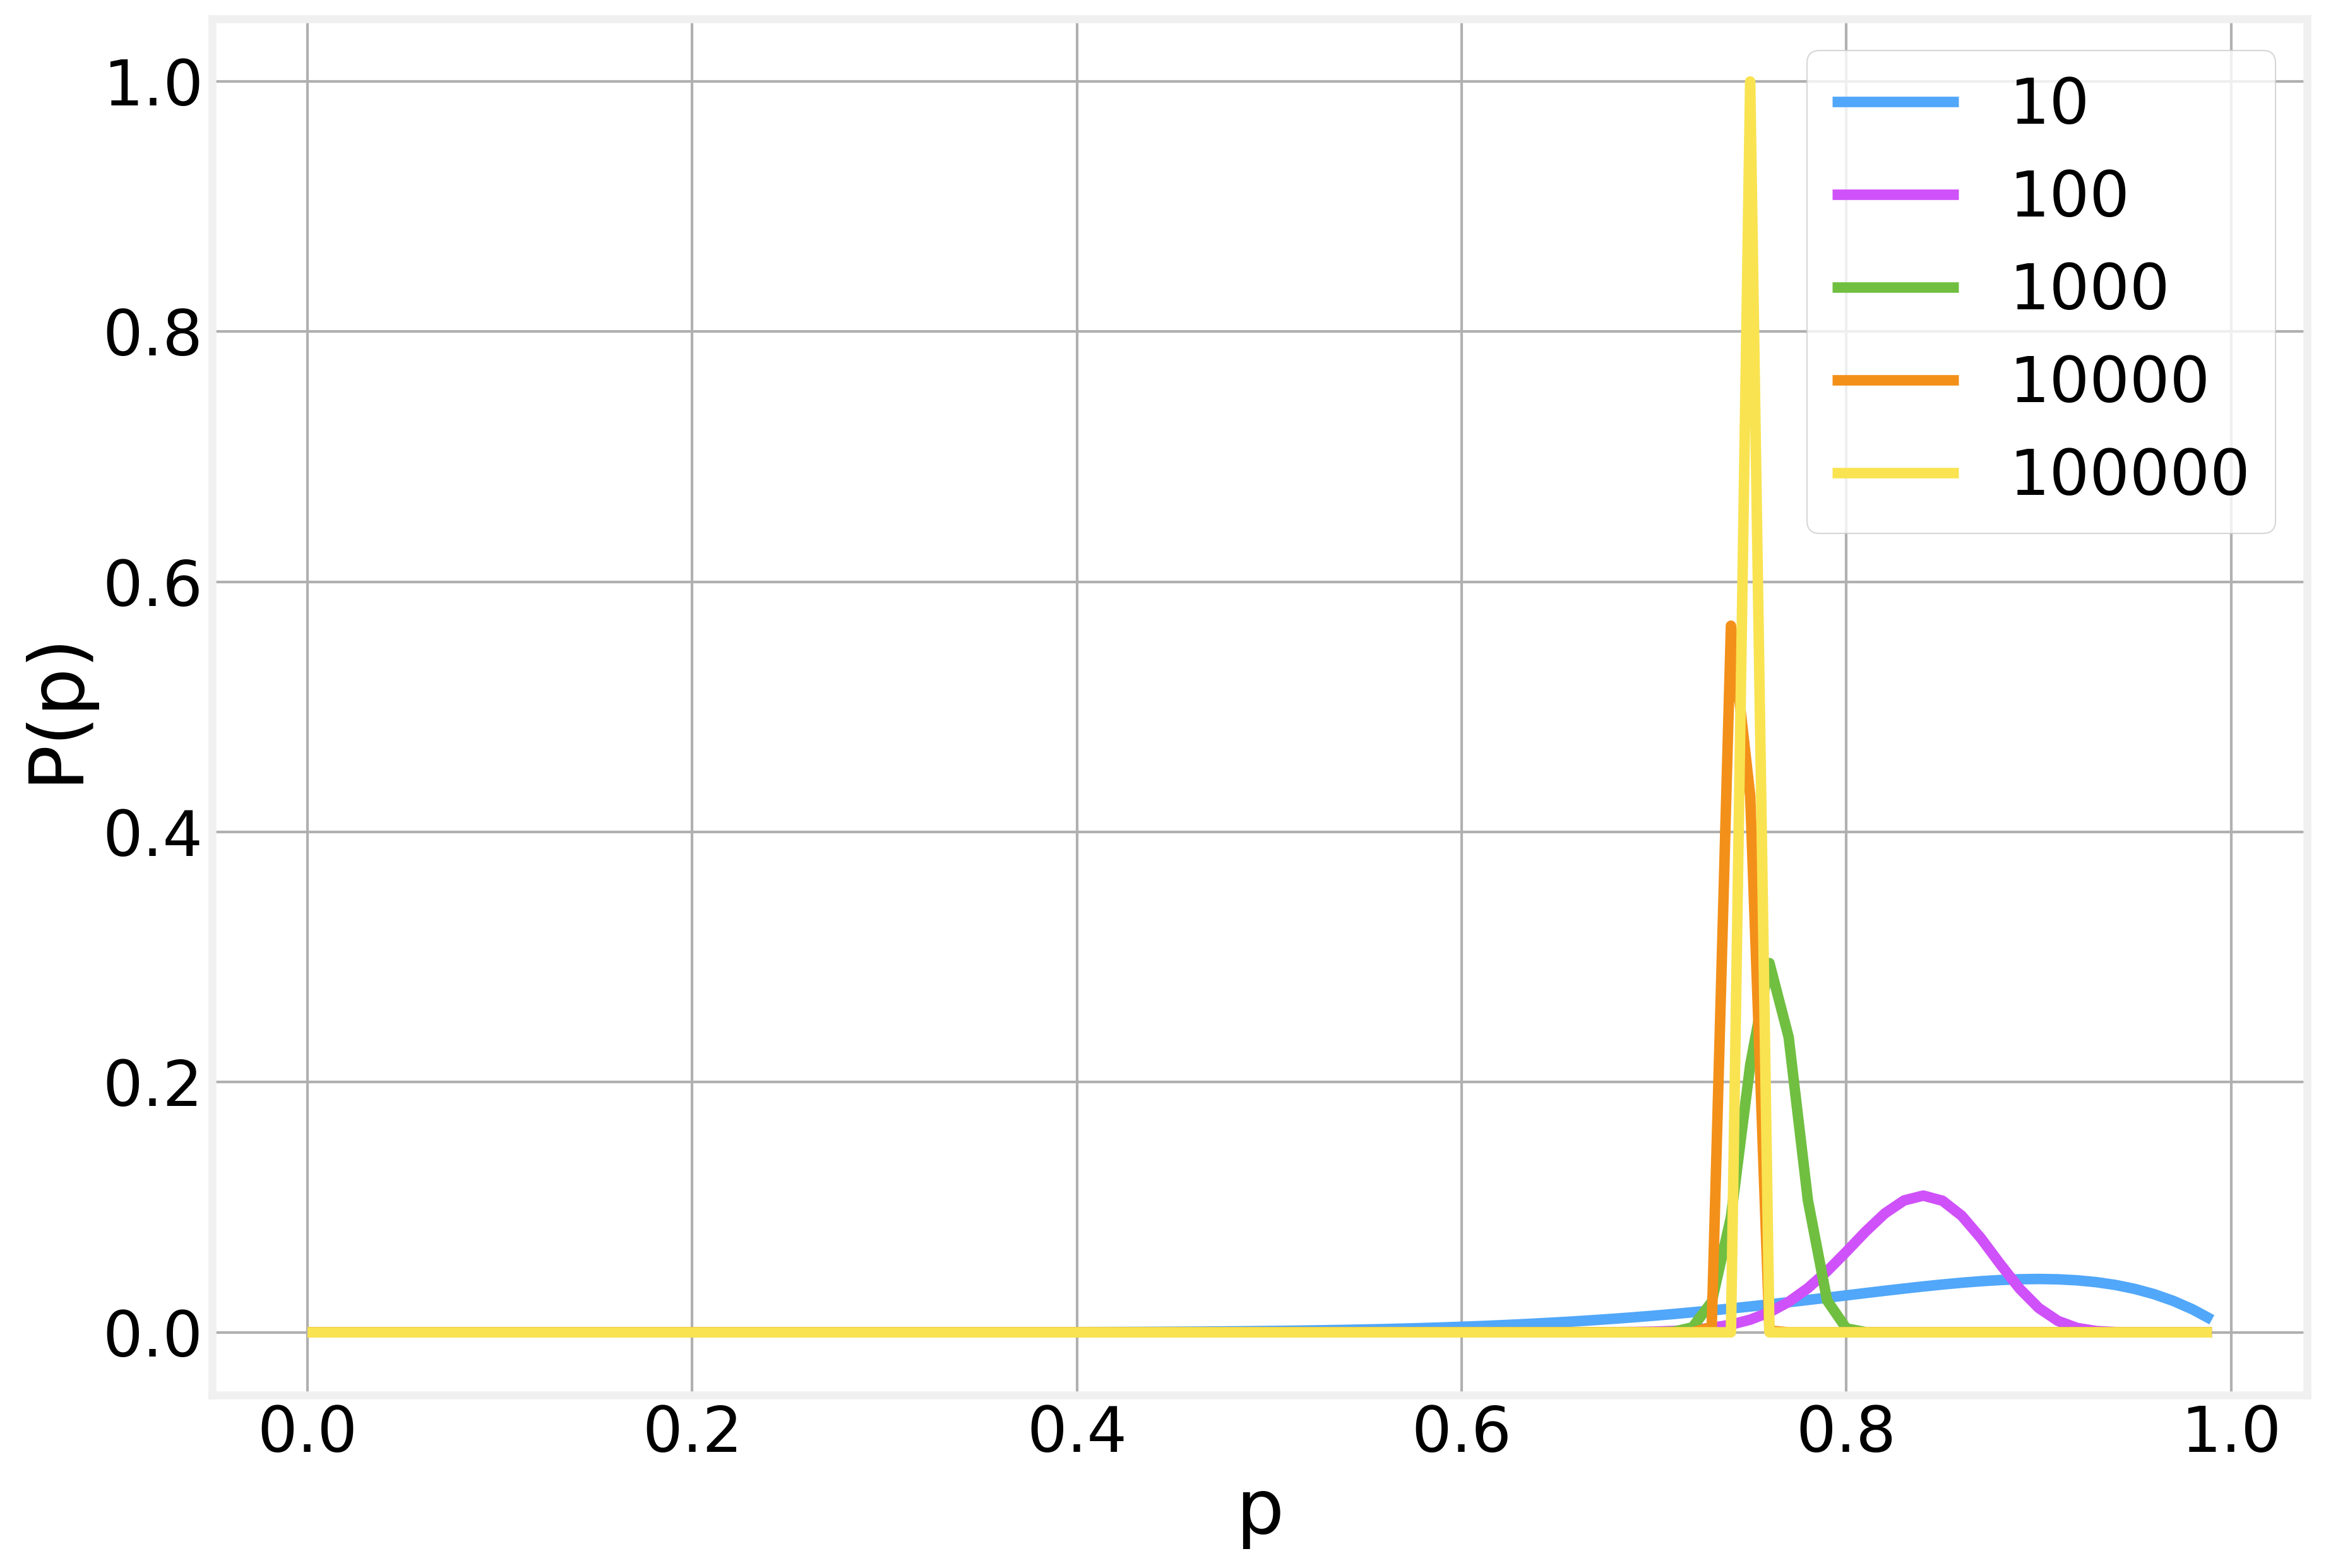

In [6]:
plt.plot(np.arange(100)/float(100), flip_coins(10))
plt.plot(np.arange(100)/float(100), flip_coins(100))
plt.plot(np.arange(100)/float(100), flip_coins(1_000))
plt.plot(np.arange(100)/float(100), flip_coins(10_000))
plt.plot(np.arange(100)/float(100), flip_coins(100_000))
plt.legend([10, 100, 1000, 10000, 100000])
plt.xlabel('p')
plt.ylabel('P(p)')

## Expectation Maximization

Inspired by http://stats.stackexchange.com/questions/72774/numerical-example-to-understand-expectation-maximization. We start by defining a function to measure the binomial log-likelihood. The logarithm is used to avoid numerical issues with small numbers

In [7]:
## E-M Coin Toss Example  ##
def get_binomial_log_likelihood(obs, probs):
    """ Return the (log)likelihood of obs, given the probs"""
    # Binomial Distribution Log PDF
    # ln (pdf)      = Binomial Coeff * product of probabilities
    # ln[f(x|n, p)] =   comb(N,k)    * num_heads*ln(pH) + (N-num_heads) * ln(1-pH)

    N = sum(obs);#number of trials  
    k = obs[0] # number of heads
    binomial_coeff = math.factorial(N) / (math.factorial(N-k) * math.factorial(k))
    prod_probs = obs[0]*math.log(probs[0]) + obs[1]*math.log(1-probs[0])
    log_lik = binomial_coeff + prod_probs

    return log_lik

This is the 'experiment' we'll be simulating, as given in the EM tutorial paper by Do and Batzoglou
- 1st:  Coin B, {HTTTHHTHTH}, 5H,5T
- 2nd:  Coin A, {HHHHTHHHHH}, 9H,1T
- 3rd:  Coin A, {HTHHHHHTHH}, 8H,2T
- 4th:  Coin B, {HTHTTTHHTT}, 4H,6T
- 5th:  Coin A, {THHHTHHHTH}, 7H,3T

so, from MLE: $p_A(heads) = 0.80$ and $p_B(heads)=0.45$

In [8]:
head_counts = np.array([5,9,8,4,7])
tail_counts = 10-head_counts
experiments = list(zip(head_counts,tail_counts))

Initialize the arrays where we'll keep track of the intermediate results

In [9]:
pA_heads = np.zeros(100)
pA_heads[0] = 0.60

pB_heads = np.zeros(100)
pB_heads[0] = 0.50

Ans we're now ready to run the EM algorithm. The flow is exactly what was described in the slides with one pass over all the *experiments* at each step

In [10]:
delta = 0.001  
j = 0 # iteration counter
improvement = float('inf')

while (improvement > delta):
    expectation_A = np.zeros((len(experiments), 2), dtype=float) 
    expectation_B = np.zeros((len(experiments), 2), dtype=float)

    wA = []
    wB = []

    for i in range(0, len(experiments)):
        e = experiments[i] # i'th experiment
        
        # loglikelihood of e given coin A:
        ll_A = get_binomial_log_likelihood(e, np.array([pA_heads[j], 1-pA_heads[j]])) 
        
        # loglikelihood of e given coin B
        ll_B = get_binomial_log_likelihood(e, np.array([pB_heads[j],1-pB_heads[j]])) 

        # corresponding weight of A proportional to likelihood of A 
        weightA = math.exp(ll_A) / ( math.exp(ll_A) + math.exp(ll_B) ) 

        # corresponding weight of B proportional to likelihood of B
        weightB = math.exp(ll_B) / ( math.exp(ll_A) + math.exp(ll_B) ) 

        expectation_A[i] = np.dot(weightA, e) 
        expectation_B[i] = np.dot(weightB, e)

        wA.append(weightA)
        wB.append(weightB)

    pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
    pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 

    improvement = ( max( abs(np.array([pA_heads[j+1], pB_heads[j+1]]) - 
                    np.array([pA_heads[j], pB_heads[j]]) )) )
    j = j+1

Finally, we visualize the results showing both the convergence and the final values

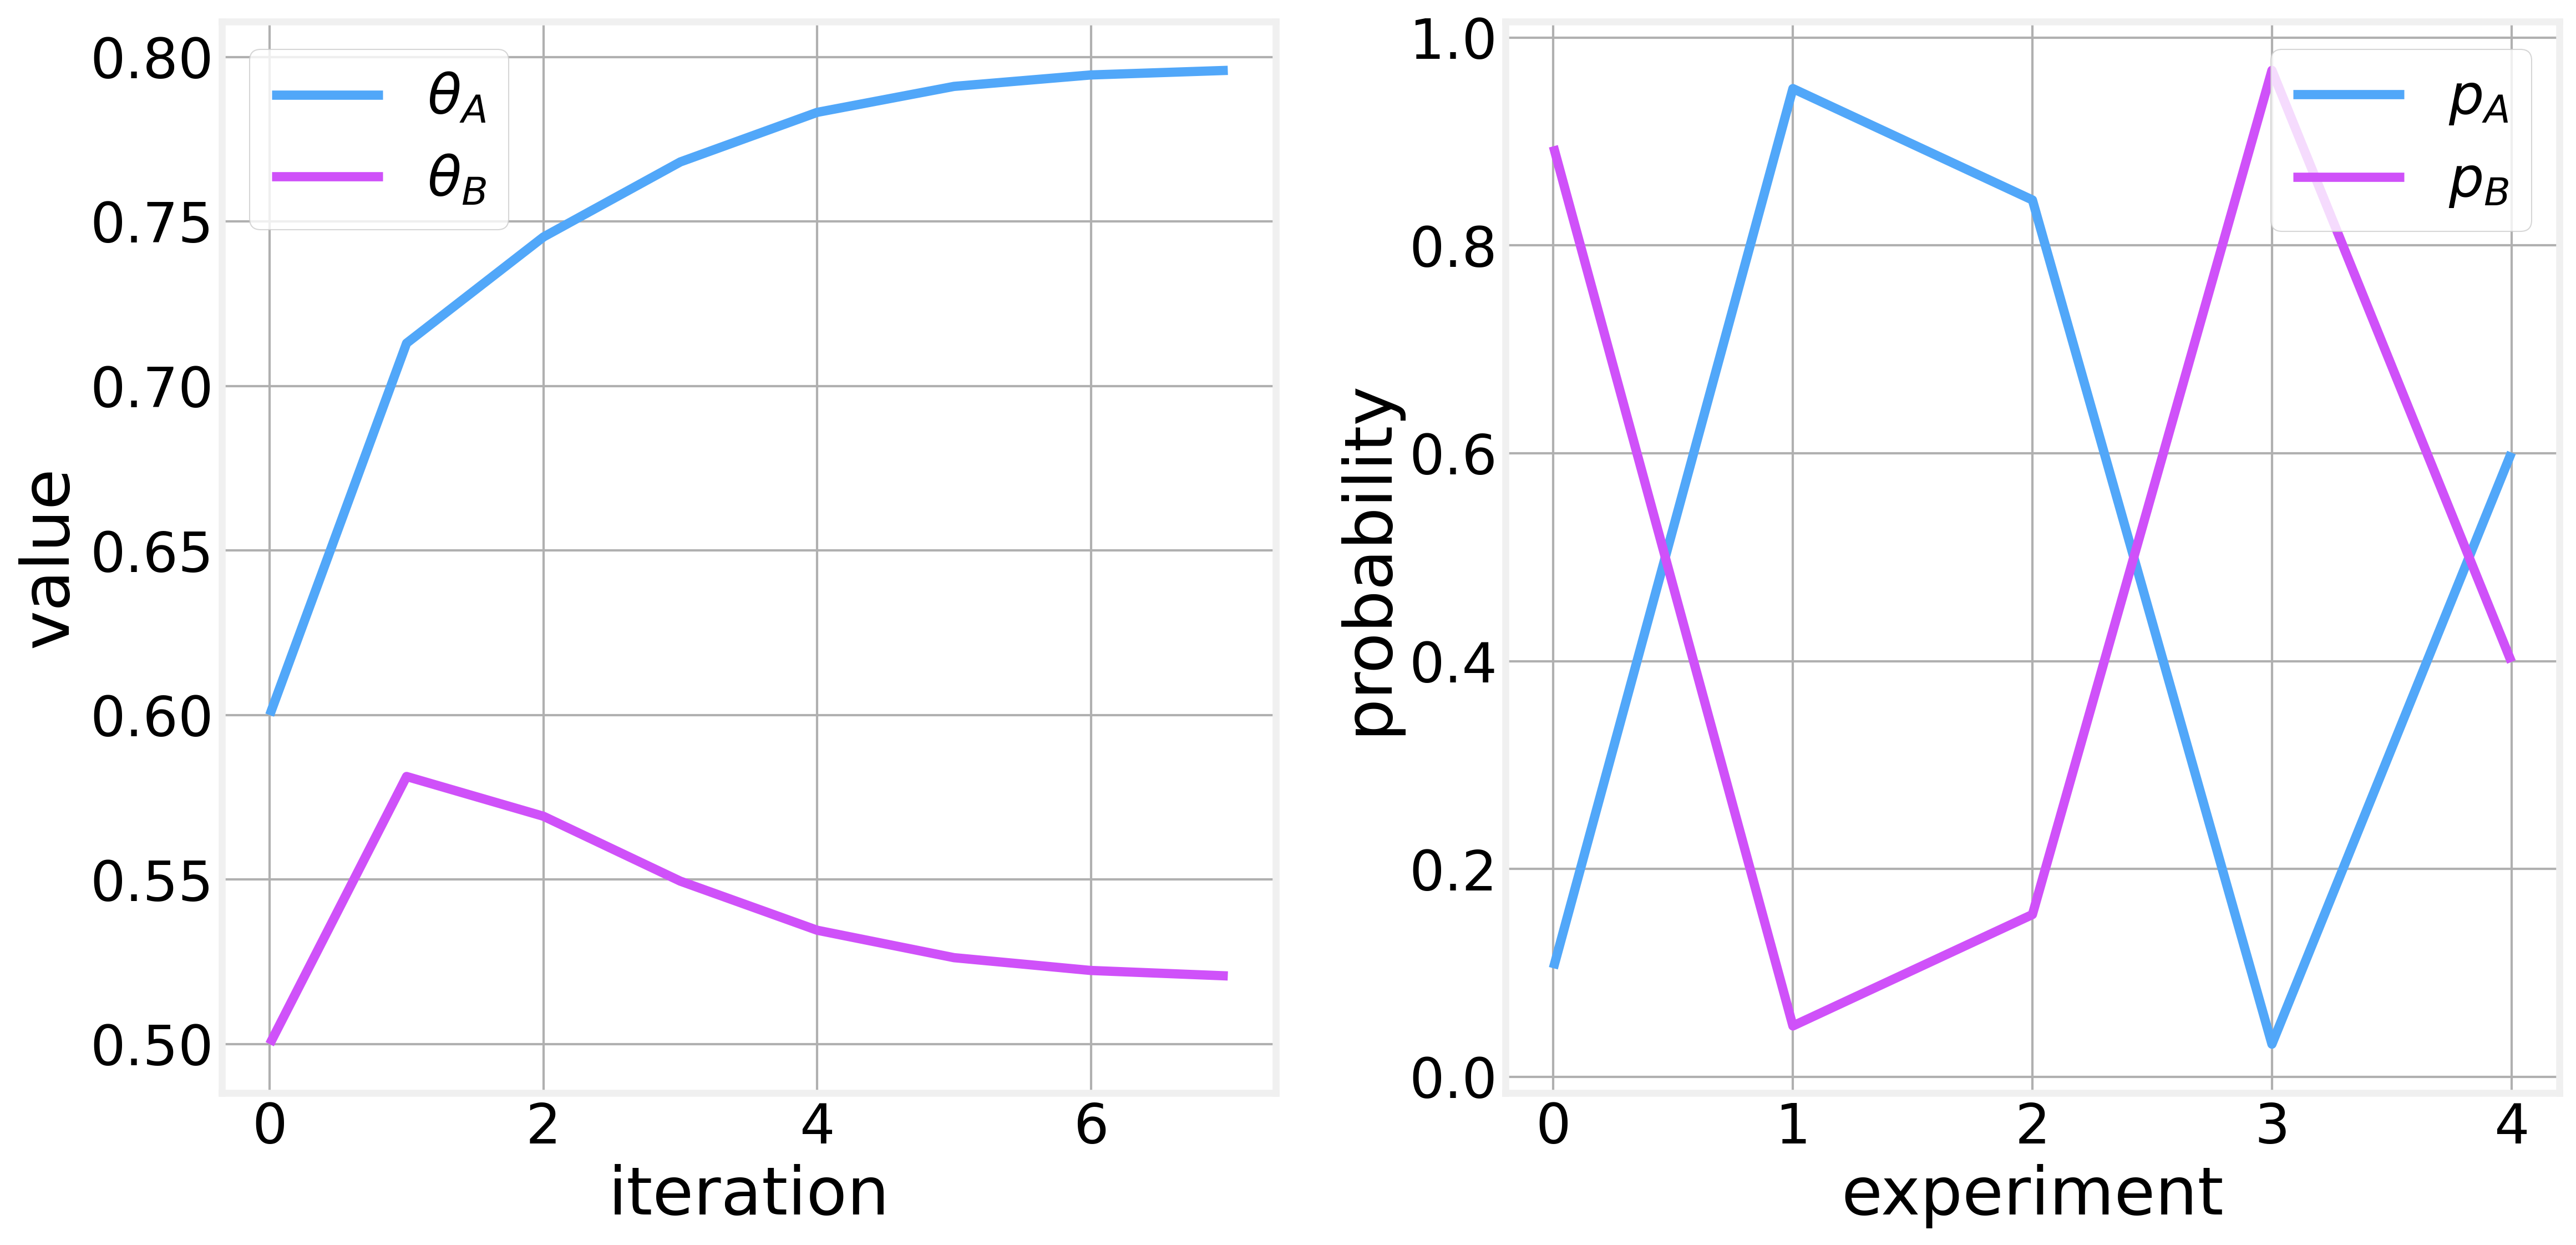

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8));
axs[0].plot(range(0,j), pA_heads[0:j], '-')
axs[0].plot(range(0,j), pB_heads[0:j], '-')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('value')
axs[0].legend([r'$\theta_A$', r'$\theta_B$'])

axs[1].plot(range(len(wA)), wA, '-')
axs[1].plot(range(len(wB)), wB, '-')
axs[1].legend([r'$p_A$', r'$p_B$'])
axs[1].set_xlabel('experiment')
axs[1].set_ylabel('probability');

## Language Detection

We now consider a more practical and uselful application, that of language detection from a piece of text. For this, we will use a dataset published by Google Books that lists how many times each word was used in each year for a large corpus of books Google scanned.

We start by building a vector of character distributions for each language. Due to the total size of the google books dataset, we include only a partial file in the data directory. The interested student is encouraged to download all teh files and use the code below to build hers or his own language detector.

In [12]:
characters = sorted(set(string.ascii_letters.lower()))

dict_char = dict(zip(characters, range(len(characters))))
counts = np.zeros(len(characters), dtype='uint64')

line_count = 0

filename = "data/googlebooks-eng-all-1gram-20120701-a.gz"

for line in gzip.open(filename, "rt"):
    fields = line.lower().strip().split()

    line_count += 1

    if line_count % 100000 == 0:
        print(filename, line_count)
        break

    count = int(fields[2])
    word = fields[0]

    if "_" in word:
        continue

    letters = [char for char in word if char in characters]

    if len(letters) != len(word):
        continue

    for letter in letters:
        if letter not in dict_char:
            continue

        counts[dict_char[letter]] += count

total = np.sum(counts)
list_char = list(dict_char.items())
list_char.sort(key=lambda x: x[1])

for key, value in enumerate(list_char):
    print(value[0], counts[key]/total)

data/googlebooks-eng-all-1gram-20120701-a.gz 100000
a 0.28373493701257363
b 0.001087943998322763
c 0.019432018645918737
d 0.002248125464286325
e 0.024034285610183632
f 0.0017618837696721584
g 0.003034393192545418
h 0.008572819698087103
i 0.038752026329494094
j 2.9965309886103013e-05
k 0.0005496779013550016
l 0.025656663800569617
m 0.006491675783290543
n 0.025316248929828675
o 0.02943861409080565
p 0.000783256279879127
q 0.001046790644919758
r 0.2529855970069149
s 0.010861035651642327
t 0.24907055561567576
u 0.002351195315185786
v 0.011610737124340345
w 0.0003748367512946128
x 4.5740451244935094e-05
y 0.0006793846191942876
z 4.9591002888668925e-05


Not surprisingly, the most common character is the letter *a*. This is an artifact of the fact that we are using the datafile containing only words that start with the letter *a*. If you were to run it on the entire dataset, the resutls shown in the slides would be found. 

For simplicity, I've also included the complete table for all 5 languages in the repository. This is the datset that we will used to build our language detector.

### Visualization

Let's start by making a quick visualization of the probabiltity distributions for each language. The first step is to load up the language character frequency from the file:

In [13]:
P_letter_lang = pd.read_csv('data/table_langs.dat', sep=' ', header=0, index_col = 0)
P_letter_lang

,eng,fre,ger,ita,spa
letter,,,,,
a,0.080878,0.079273,0.056858,0.106003,0.118567
b,0.014995,0.009248,0.019252,0.009195,0.012695
c,0.033603,0.034258,0.029708,0.043358,0.041908
d,0.037993,0.042269,0.055100,0.039737,0.056807
e,0.124356,0.159318,0.171683,0.120918,0.141615
f,0.023742,0.011307,0.014223,0.011287,0.007753
g,0.018841,0.009354,0.029163,0.017394,0.010725
h,0.050015,0.007948,0.043346,0.009352,0.007654
i,0.075937,0.074125,0.086132,0.115072,0.063506


The frequency of each letter in the English language

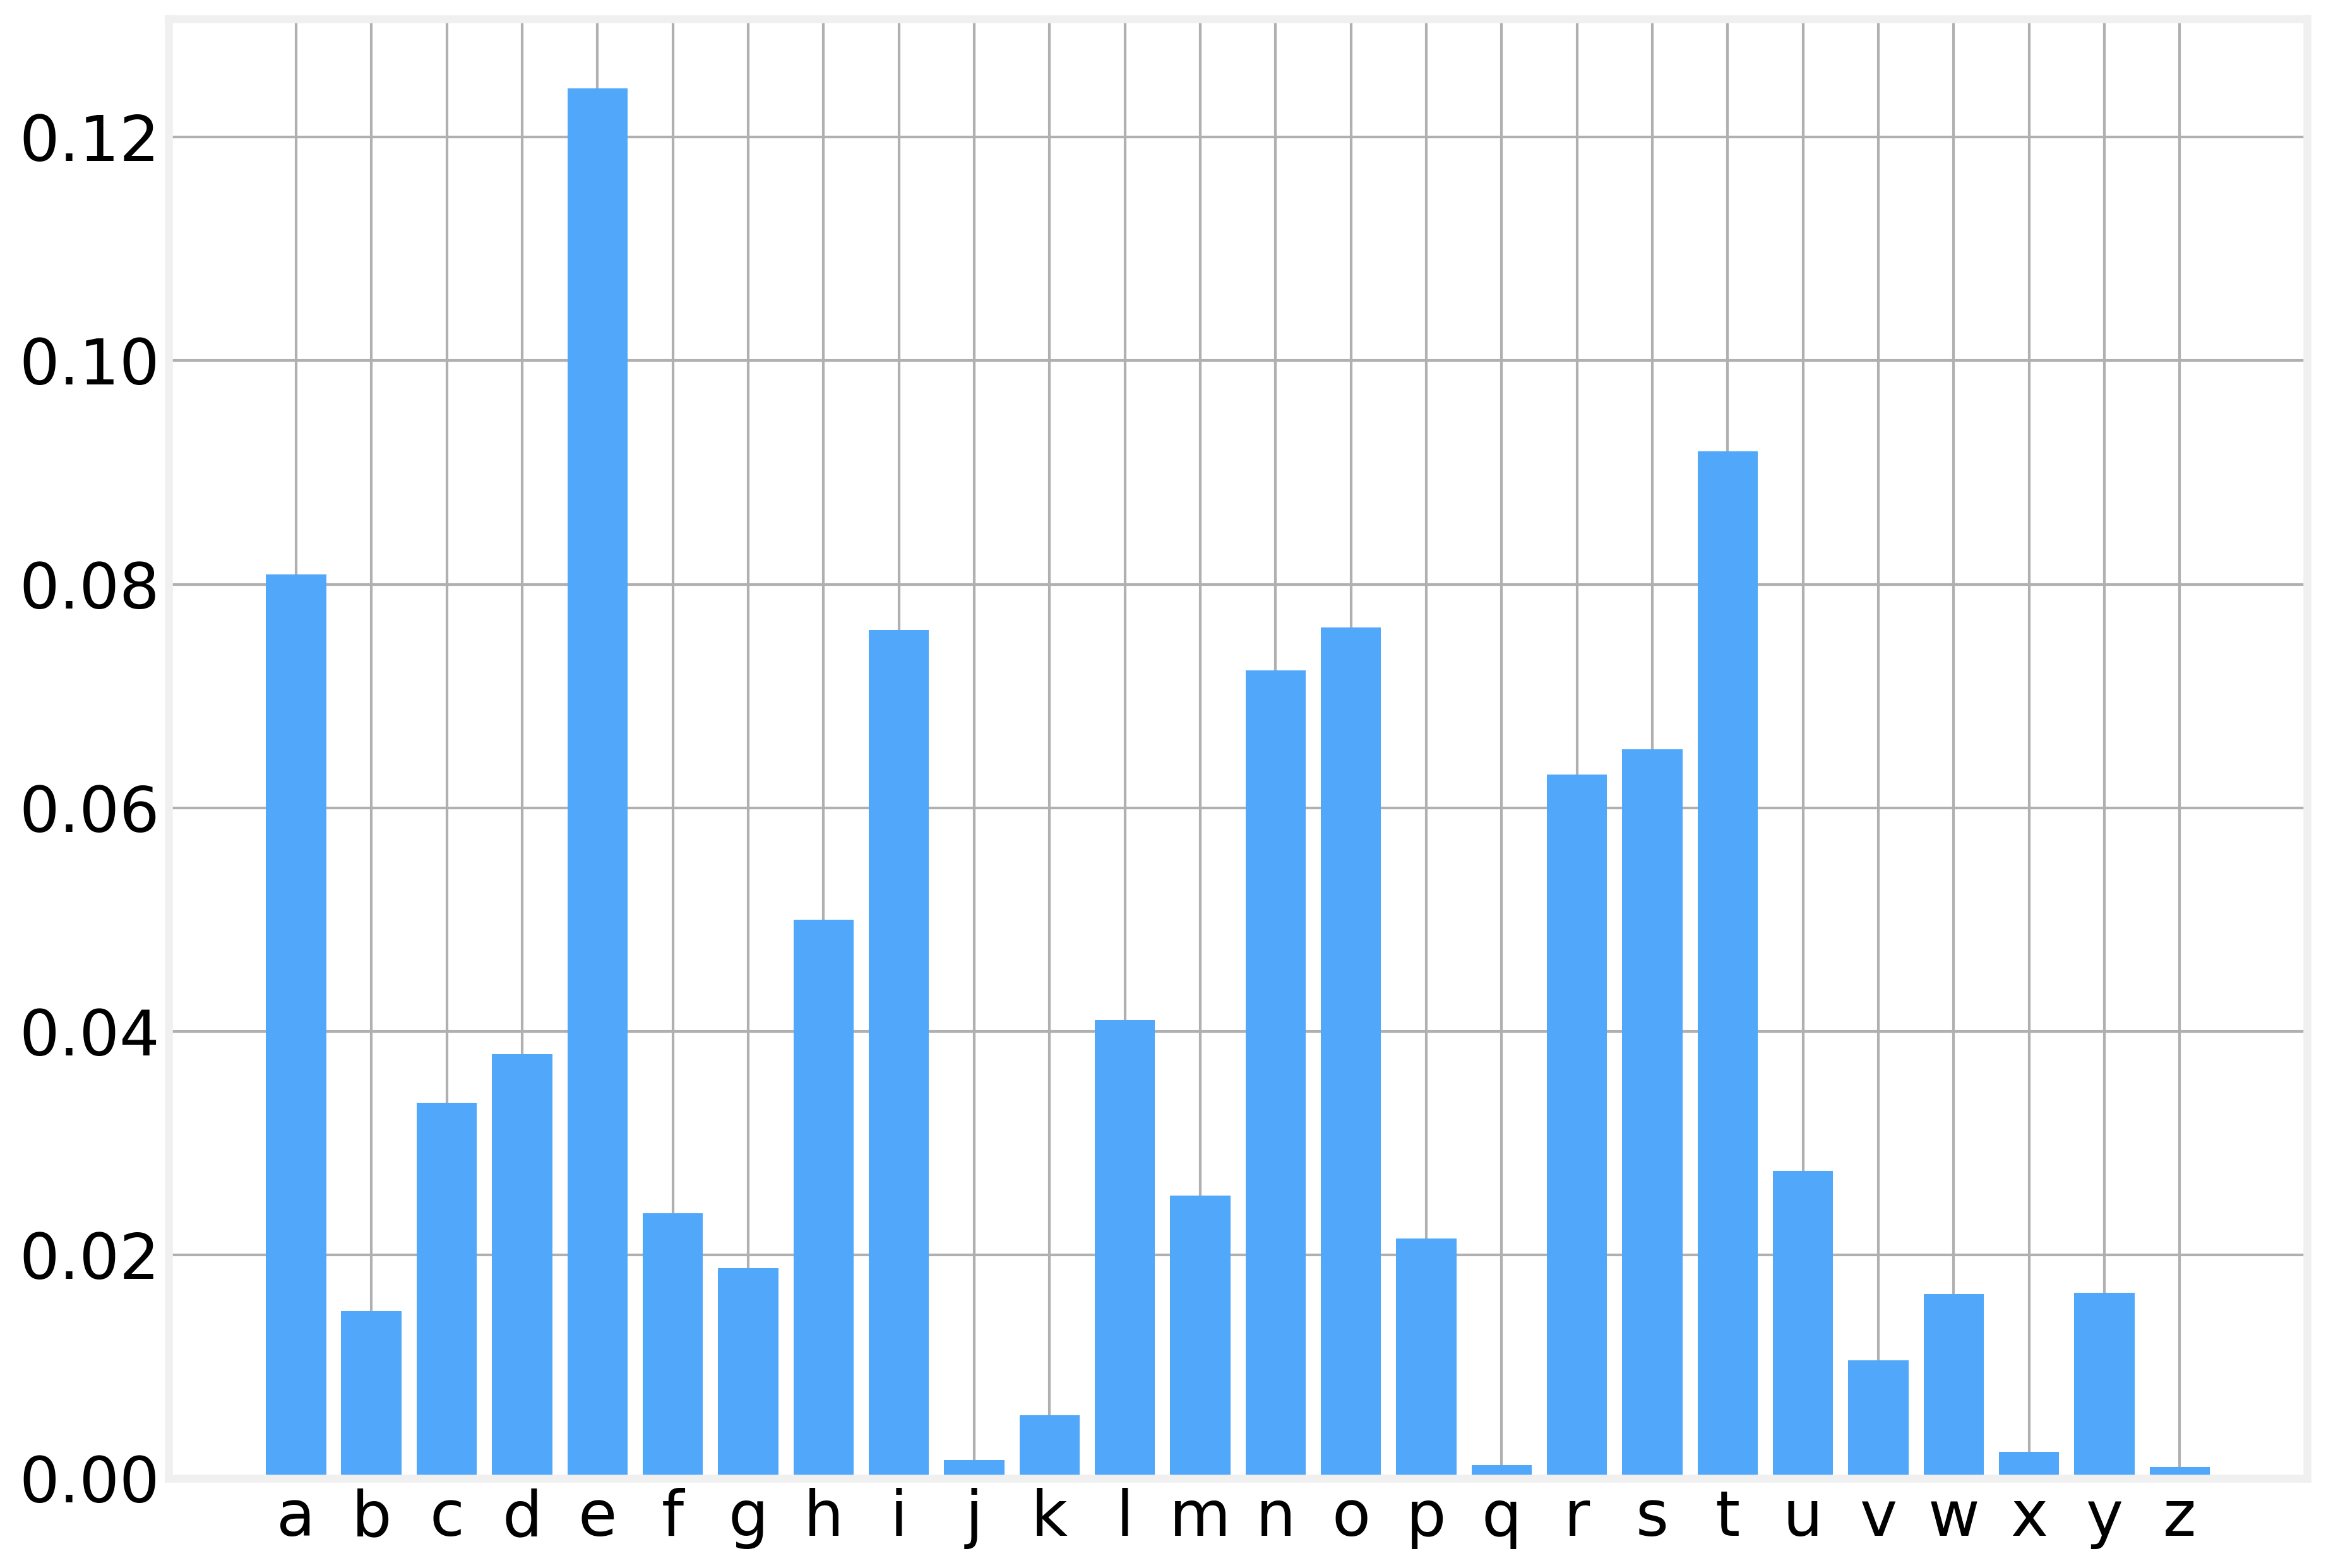

In [14]:
plt.bar(range(26), P_letter_lang["eng"])
plt.xticks(list(range(26)), P_letter_lang.index);

And the comparison across all five languages

Text(0, 0.5, 'P(letter | language)')

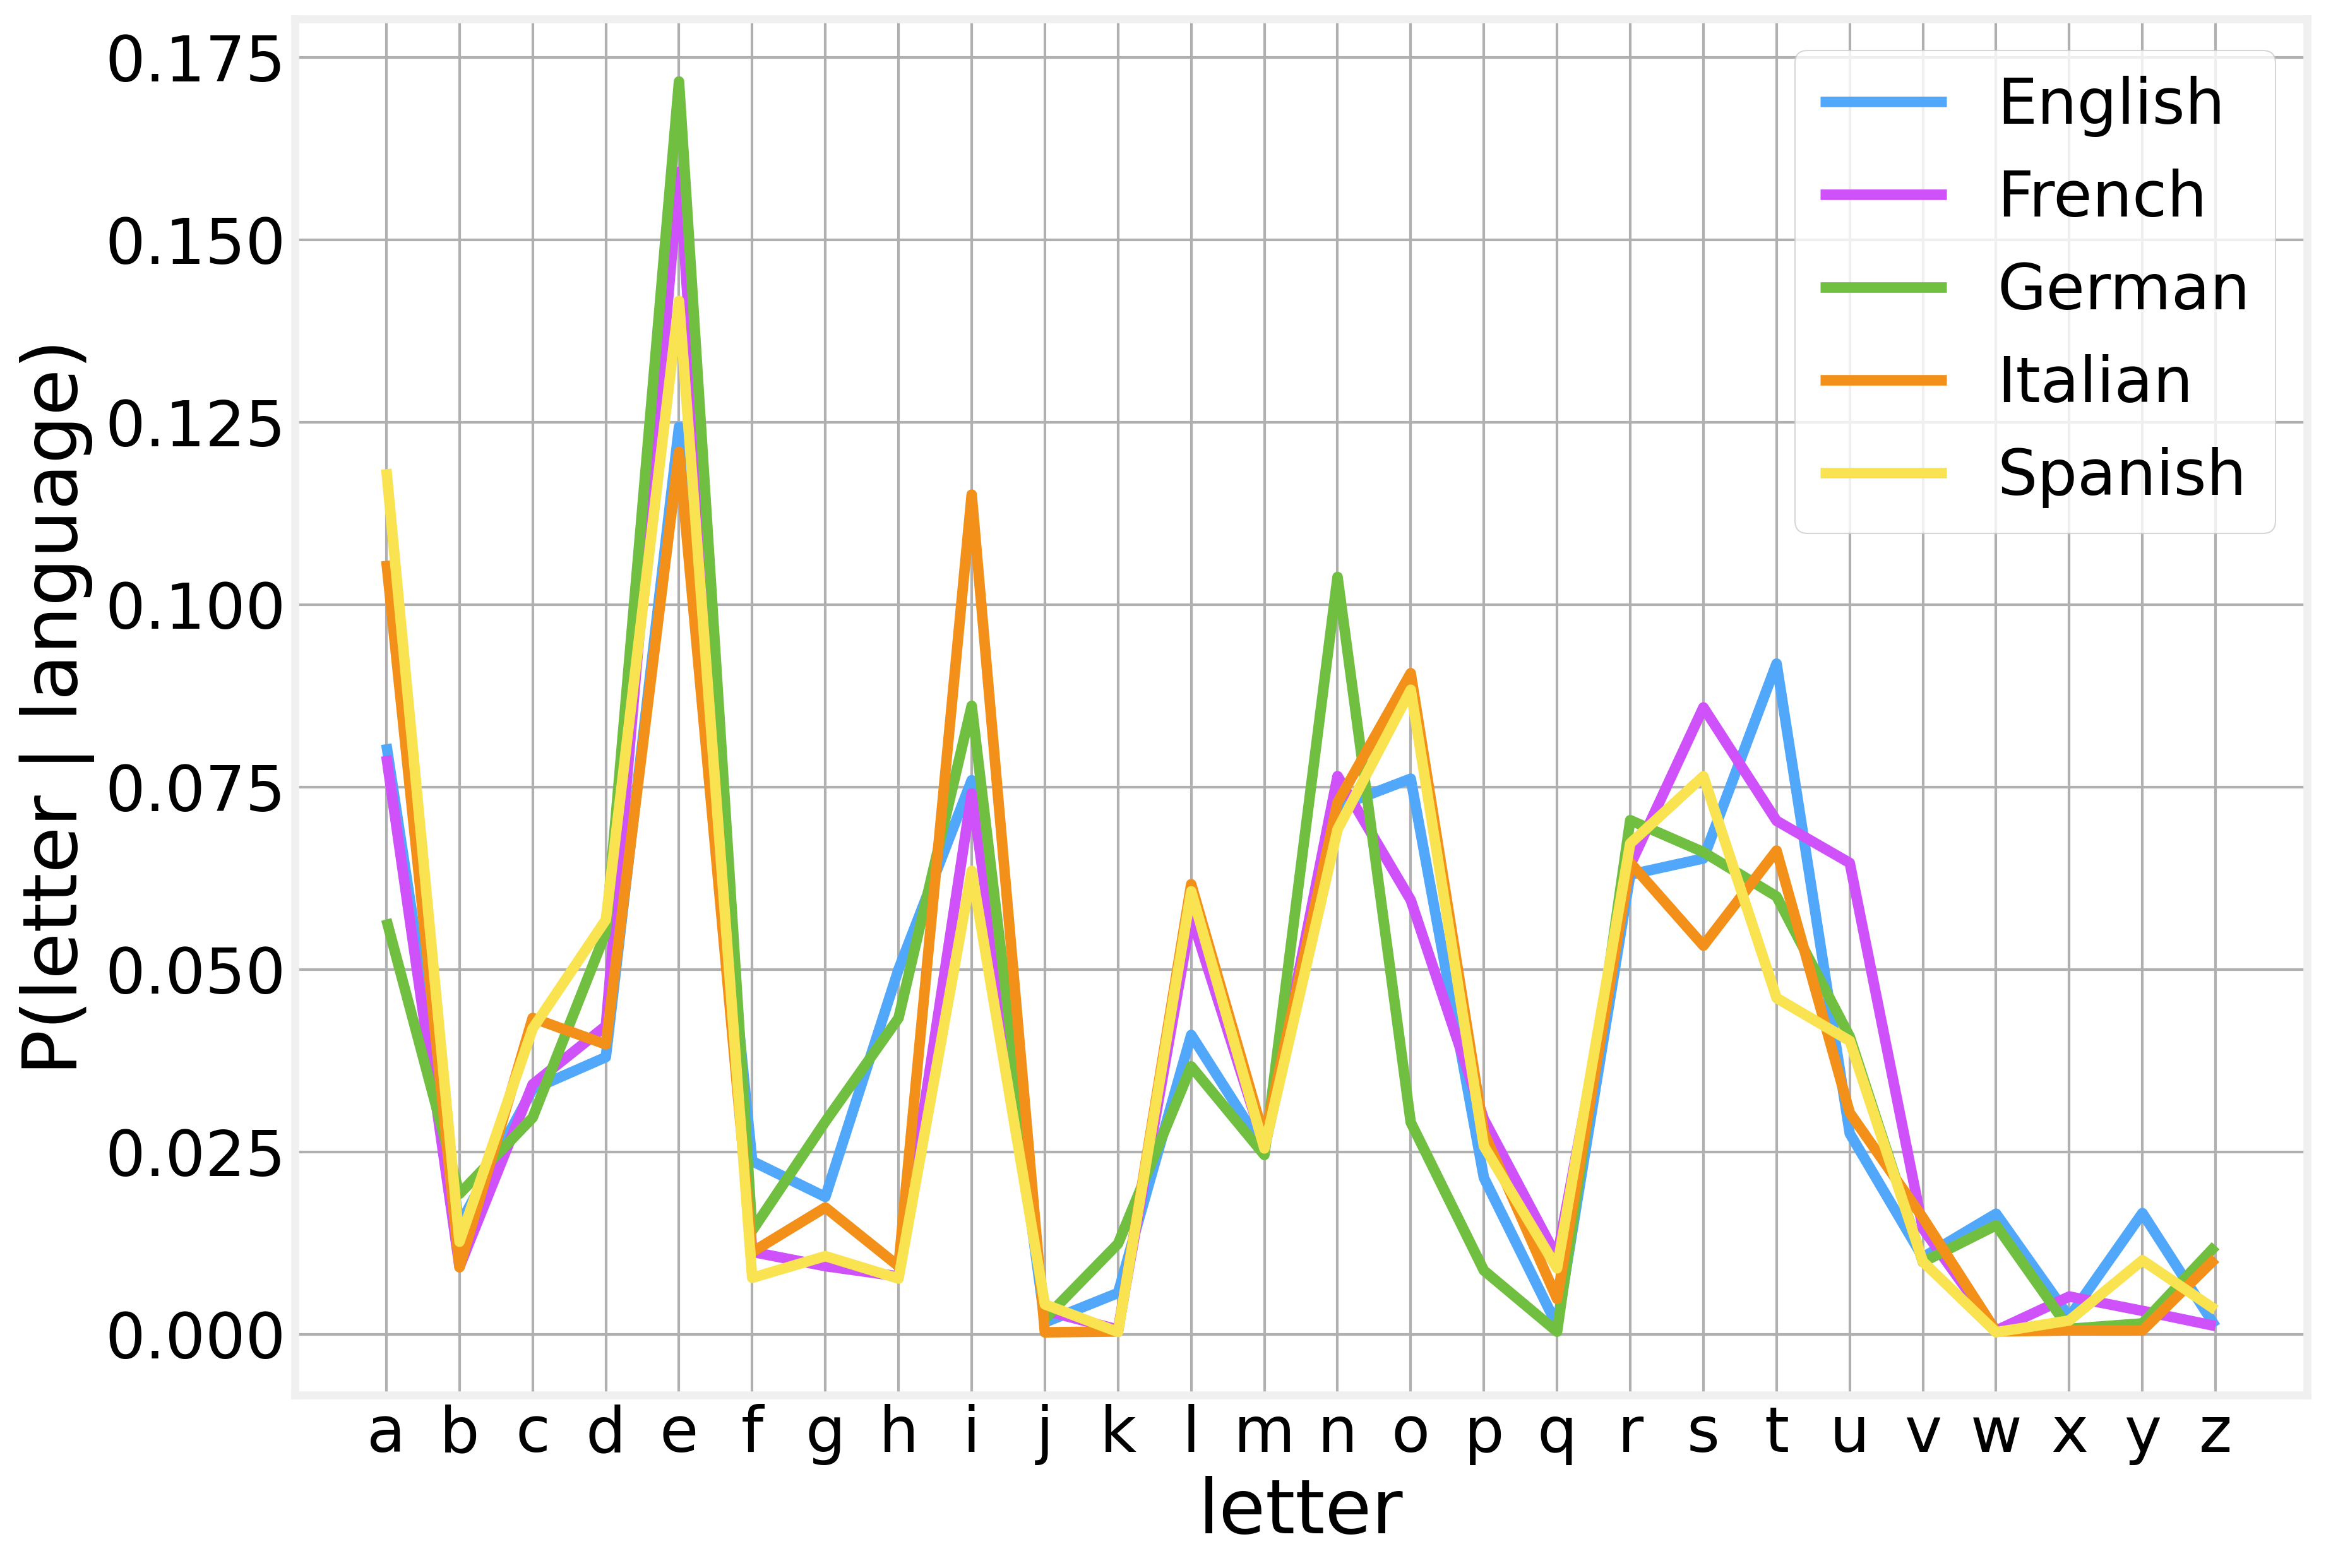

In [15]:
plt.plot(range(26), P_letter_lang["eng"], '-')
plt.plot(range(26), P_letter_lang["fre"], '-')
plt.plot(range(26), P_letter_lang["ger"], '-')
plt.plot(range(26), P_letter_lang["ita"], '-')
plt.plot(range(26), P_letter_lang["spa"], '-')
plt.xticks(list(range(26)), P_letter_lang.index)
plt.legend(["English", "French", "German", "Italian", "Spanish"])
plt.xlabel("letter")
plt.ylabel("P(letter | language)")

As we can see, there definitely some common trends (the letters *q* and *j* are underrepreented across all languages), there are also some significant peaks that will help us discriminate between one language and the next.

### The detector

Based on this table of data it is extremely simple to build a Naive Bayes classifier. To do so, one must simply use Bayes Theorem to determine the probability of the language given the characters observed. Here we calculate the likelihoods we will use

In [16]:
def process_data(P_letter_lang):
    langs = list(P_letter_lang.columns)

    P_letter = P_letter_lang.mean(axis=1)
    P_letter /= P_letter.sum()

    P_lang_letter = np.array(P_letter_lang)/(P_letter_lang.shape[1]*P_letter.T[:,None])

    L_lang_letter = np.log(P_lang_letter.T)

    return langs, P_letter, L_lang_letter

In [17]:
langs, P_letter, L_lang_letter = process_data(P_letter_lang)

<ipython-input-16-c1b00d69412f>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  P_lang_letter = np.array(P_letter_lang)/(P_letter_lang.shape[1]*P_letter.T[:,None])


Finally, we have all the tools we need to write down our mini detector:

In [18]:
def detect_lang(langs, P_letter, L_lang_letter, text):
    counts = np.zeros(26, dtype='int')
    pos = dict(zip(P_letter.index, range(26)))

    text_counts = Counter(text).items()

    for letter, count in text_counts:
        if letter in pos:
            counts[pos[letter]] += count

    L_text = np.dot(L_lang_letter, counts)
    index = np.argmax(L_text)
    lang_text = langs[index]
    prob = np.exp(L_text[index])/np.sum(np.exp(L_text))*100

    return lang_text, prob, L_text

And that's all there is to it. So now let's test our detector with a few past headlines from Google News:

In [19]:
texts = {}
texts["eng"] = "North Korea’s Test of Nuclear Bomb Amplifies a Global Crisis".lower()
texts["ita"] = "Nucleare, Onu riunisce consiglio sicurezza. E Seul simula attacco alle basi di Kim".lower()
texts["fre"] = "Corée du Nord : les Etats-Unis prêts à utiliser leurs capacités nucléaires".lower()
texts["spa"] = "Estados Unidos amenaza con una “respuesta militar masiva” a Corea del Norte".lower()
texts["ger"] = "Überraschung".lower()
texts["ita2"] = "Wales lancia la Wikipedia delle news. Contro il fake in campo anche Google".lower()

for lang in texts:
    text = texts[lang]
    lang_text, prob, L_text = detect_lang(langs, P_letter, L_lang_letter, text)
    print(lang, lang_text, prob, text)

eng eng 91.87493065763115 north korea’s test of nuclear bomb amplifies a global crisis
ita ita 94.20224266512197 nucleare, onu riunisce consiglio sicurezza. e seul simula attacco alle basi di kim
fre fre 94.90751389582378 corée du nord : les etats-unis prêts à utiliser leurs capacités nucléaires
spa spa 58.428648006919225 estados unidos amenaza con una “respuesta militar masiva” a corea del norte
ger ger 70.51752677149888 überraschung
ita2 eng 97.44427974112531 wales lancia la wikipedia delle news. contro il fake in campo anche google


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>